In [1]:
import datetime as dt
import pandas as pd

### Load Data

In [2]:
df = pd.read_excel("/Users/masc/Desktop/MDM/online_retail_II.xlsx")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Data preprocessing

In [3]:
df.shape

(525461, 8)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0,10.337667,107.424110,-9600.00,1.00,3.0,10.00,19152.00
Price,525461.0,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.0,16799.00,18287.00


In [5]:
#removing negative values in Quantity and Price
df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]

#df.describe()
df.shape

(511566, 8)

In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    103902
Country             0
dtype: int64

There are missing values in Description and Customer ID columns, we will remove them from the DataFrame. Also, nn the DataFrame there are some invoices that include "C" in Invoice column which means that they are cancelled transactions so we will remove them from our DataFrame

In [7]:
df.dropna(inplace=True)
#df = df[~df["Invoice"].str.contains("C", na=False)]

There should be no negative value in Quantity and Price columns.

In [8]:
#removing negative values in Quantity and Price
df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]

#df.describe()
df.shape

(407664, 8)

In [9]:
#Create a variable named 'TotalPrice' that represents the total earnings per invoice

df["TotalPrice"] = df["Quantity"] * df["Price"]

#df.describe()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### RFM Analysis

In [10]:
# Defining Recency as two of the three columns in data:
recency = df[['InvoiceDate', 'Customer ID']]

In [11]:
# now refers to the latest date available in the data, to which we will peg our rececny dimensions on:
now = max(df['InvoiceDate'])

The groupby function in pandas allows of for grouping of many index column values or as we saw above there were more than one instances of a single customer purchasing so why not combine all their purchases?

In [12]:
recency = recency.groupby(['Customer ID']).max()

Recency refers to the time since the last purchase. So lets find out the number of days:

In [13]:
recency_days = now - recency['InvoiceDate']

In [14]:
recency_days = pd.DataFrame(recency_days)
recency_days.head()

,InvoiceDate
Customer ID,
12346.0,164 days 06:08:00
12347.0,2 days 05:04:00
12348.0,73 days 05:02:00
12349.0,42 days 11:38:00
12351.0,10 days 04:38:00


Monetary refers to the total money spent by a customer overtime:

In [15]:
monetary = df[['Customer ID', 'Quantity']]

Via Groupby here, I sum up all the transactions of every respective customer:

In [16]:
monetary = monetary.groupby(['Customer ID']).sum()

monetary.head()

,Quantity
Customer ID,
12346.0,70
12347.0,828
12348.0,373
12349.0,993
12351.0,261


Frequency refers to the number of times a customer has made purchases:

In [17]:
frequency = df[['Customer ID', 'InvoiceDate']]

Via Groupby, I use count to count the number of times the customer has made purchases:

In [18]:
frequency = frequency.groupby(['Customer ID']).count()
frequency.head()

,InvoiceDate
Customer ID,
12346.0,33
12347.0,71
12348.0,20
12349.0,102
12351.0,21


Finally concatenating the dataframes:

In [19]:
recency = pd.DataFrame(recency_days['InvoiceDate'].astype('timedelta64[D]'))
recency.columns = ['recency']

recency.head()

,recency
Customer ID,
12346.0,164.0
12347.0,2.0
12348.0,73.0
12349.0,42.0
12351.0,10.0


Since we have the absolute integer values of all the three key elements lets concatenate them:

In [20]:
rfm = pd.concat([recency, frequency, monetary], axis=1)

In [21]:
# Defining the columns:
rfm.columns=['recency', 'frequency', 'monetary']

rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,164.0,33,70
12347.0,2.0,71,828
12348.0,73.0,20,373
12349.0,42.0,102,993
12351.0,10.0,21,261


recency         AxesSubplot(0.125,0.749828;0.133621x0.130172)
frequency    AxesSubplot(0.285345,0.749828;0.133621x0.130172)
monetary      AxesSubplot(0.44569,0.749828;0.133621x0.130172)
dtype: object

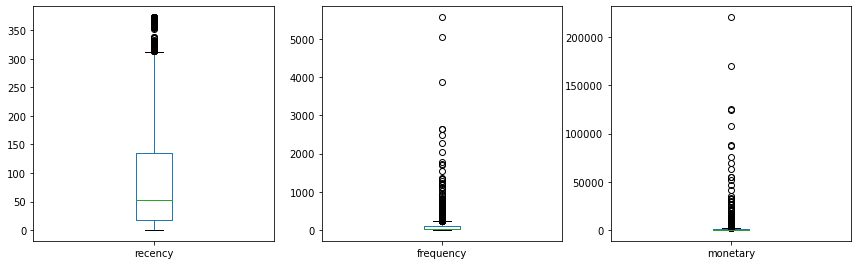

In [22]:
#checking the outliers

rfm.plot(kind="box", subplots=True, layout=(5,5), figsize=(25,25))

In [23]:
#Delete outliers

cols = ['recency', 'frequency', 'monetary' ] # one or more

Q1 = rfm[cols].quantile(0.25)
Q3 = rfm[cols].quantile(0.75)
IQR = Q3 - Q1

rfm = rfm[~((rfm[cols] < (Q1 - 1.5 * IQR)) |(rfm[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]



/Users/masc/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Days since last purchase')

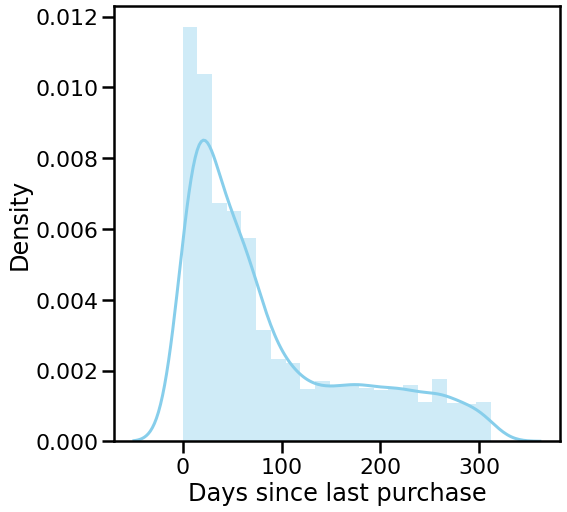

In [24]:
# Plotting for the last day since the customer made a purchase:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['skyblue'])
sns.distplot(rfm['recency'])
plt.xlabel('Days since last purchase')

/Users/masc/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='frequency', ylabel='Density'>

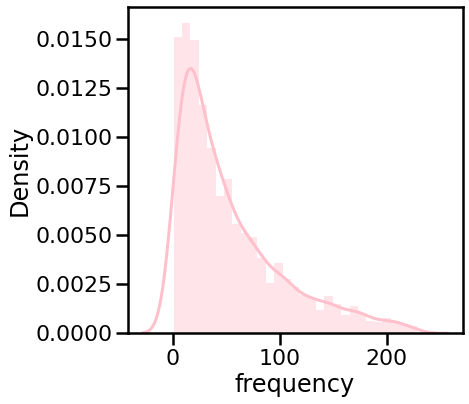

In [25]:
# Plotting the number of times the customer has made a purchase:

plt.figure(figsize=(6,6))
sns.set_context("poster")
sns.set_palette(['pink'])
sns.distplot(rfm['frequency'])

/Users/masc/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Dollars')

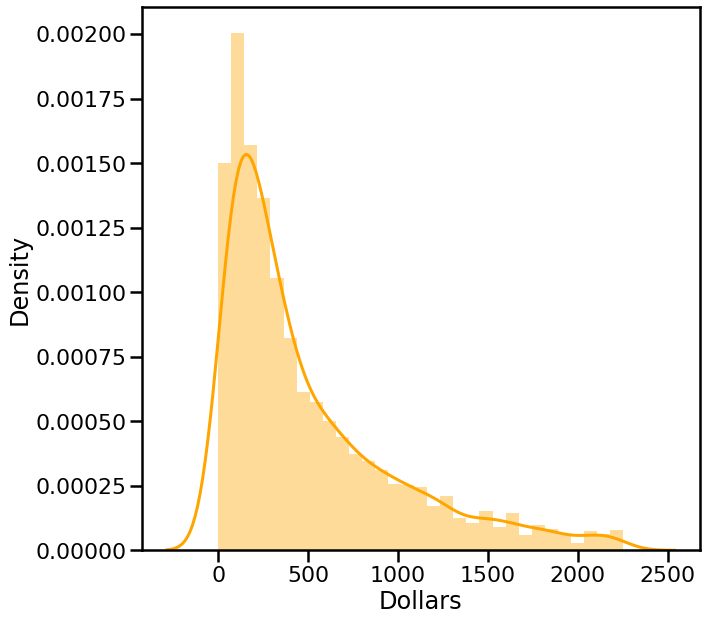

In [26]:
# Plotting the total revenue that the particular customer brought in to the shop:

plt.figure(figsize=(10,10))
sns.set_context("poster")
sns.set_palette(['orange'])
sns.distplot(rfm['monetary'])
plt.xlabel('Dollars')

After getting a basic idea of what the distribution of the three indicators, we use quantiles to analyse further with quantiles.

### K-Means Model

) Preprocessing the data to find the three key elements needed:

    - Recency
    - Frequency
    - Monetary Value

2) Using the KMeans Algorithm to find the cluster of customers with high average monetary value and are highly frequent.

3) The cluster taken out now would be put through RFM Analysis and processed.

4) Customers with the highest Aggregate RFM Scores would be considered the Actual Superfans.

In [54]:
# Making a copy so that I don't lose my temper over messing up a previously perfect dataframe.
RFM = rfm.copy()

# Importing KMeans and finding clusters:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 4, init = 'k-means++')

nclusters = km.fit_predict(RFM)

clusters = pd.DataFrame(nclusters, columns = ['clusters'], index = RFM.index)

# Concatenating the clusters with the RFM dataframe:
rfmK= pd.concat([RFM, clusters], axis=1)

<AxesSubplot:xlabel='frequency', ylabel='monetary'>

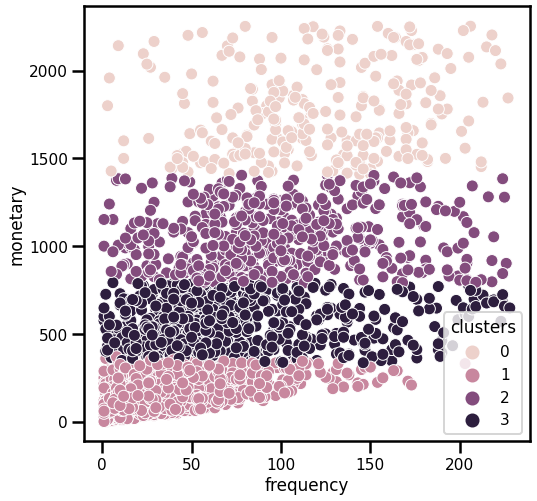

In [55]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = rfmK, x='frequency', y='monetary', hue='clusters')

Since it is clear that the cluster with the number 2 as its index has the highest frequency and monetary value, lets use it. The clusters with the index as 1 are the thrifty customers who don't visit the shop that much and don't pay much too. 0 and 3 are in between the extremes.

In [56]:
RFMKMEANS = rfmK.copy()

RFMKMEANS['clusters'] = ['SuperFans' if x == 3 else x for x in RFMKMEANS['clusters']]
RFMKMEANS['clusters'] = ['UsualCustomers' if x == 2 else x for x in RFMKMEANS['clusters']]
RFMKMEANS['clusters'] = ['FrequentCustomers' if x == 0 else x for x in RFMKMEANS['clusters']]
RFMKMEANS['clusters'] = ['Thrifters' if x == 1 else x for x in RFMKMEANS['clusters']]

/Users/masc/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='clusters', ylabel='count'>

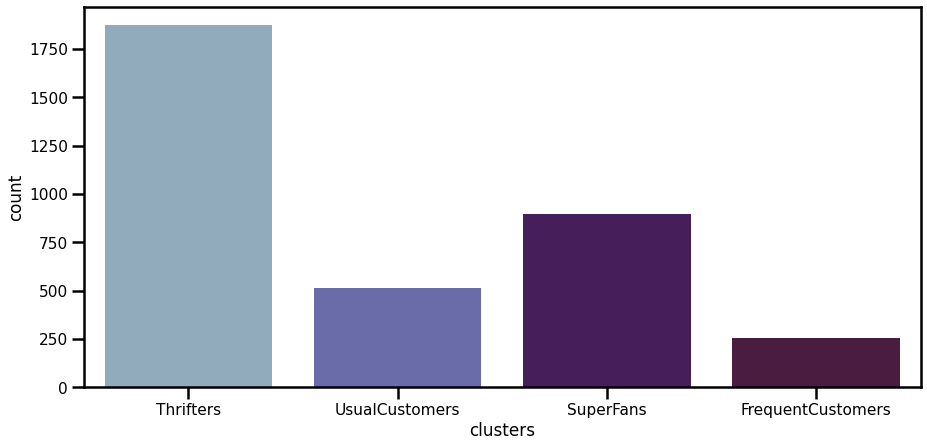

In [57]:
plt.figure(figsize=(15,7))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(RFMKMEANS['clusters'])

Since, we have the cluster, now seperate the cluster from the dataframe:

In [58]:
superfans_df = rfmK.loc[rfmK['clusters'] == 2]
superfans_df.head()

,recency,frequency,monetary,clusters
Customer ID,,,,
12347.0,2.0,71,828,2
12349.0,42.0,102,993,2
12358.0,10.0,58,831,2
12359.0,60.0,117,1130,2
12360.0,14.0,88,1294,2


In [59]:
# Dropping the clusters column because there's just a single value which is 2 in the whole column:
superfans_df.drop(['clusters'], axis= 1, inplace=True)

/Users/masc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [71]:
# Lets take a look at the quantile:
superfans_df.quantile([.25, .5, .75, 1], axis=0)

,recency,frequency,monetary
0.25,14.0,64.0,902.00
0.50,35.0,91.0,1026.00
0.75,71.0,125.0,1171.75
1.00,304.0,226.0,1404.00


In [72]:
# Copying the RFM dataset so that it isn't affected by the changes:
RFMscores = superfans_df.copy()

Below is the conversion of columns into RFM scores between 1 to 4. These will come handy in calculating the aggregate RFM Score. As per the quantile have been assigned the indices in the columns a value between 1 to 4.

'4' being great and '1' being poor.

Apart from that what must be noted is that different columns see this score differently. Such as, the higher the monetary value the higher chance of that value being 4 since more revenue is never a bad thing. While, smaller the value of Recency the more likely it is that the index will be given the value of 1, since the more recent customer is more likely to comeback. In case of Frequency the metrics are the same as Monetary since, higher the Frequency the more beneficial it is for business.

In [73]:
# Converting Recency:

RFMscores['recency'] = [4 if x <= 14 else x for x in RFMscores['recency']]
RFMscores['recency'] = [3 if 14 < x <= 35 else x for x in RFMscores['recency']]
RFMscores['recency'] = [2 if 35 < x <= 71 else x for x in RFMscores['recency']]
RFMscores['recency'] = [1 if x > 71 else x for x in RFMscores['recency']]

In [74]:
# Converting Frequency:

RFMscores['frequency'] = [1 if a <= 64 else a for a in RFMscores['frequency']]
RFMscores['frequency'] = [2 if 64 < a <= 91 else a for a in RFMscores['frequency']]
RFMscores['frequency'] = [3 if 91 < a <= 125 else a for a in RFMscores['frequency']]
RFMscores['frequency'] = [4 if a > 125 else a for a in RFMscores['frequency']]

In [75]:
# Converting Monetary:

RFMscores['monetary'] = [1 if x <= 902 else x for x in RFMscores['monetary']]
RFMscores['monetary'] = [2 if 902 < x <= 1026 else x for x in RFMscores['monetary']]
RFMscores['monetary'] = [3 if 1026 < x <= 1171.75 else x for x in RFMscores['monetary']]
RFMscores['monetary'] = [4 if x > 1171.75  else x for x in RFMscores['monetary']]

check if we got it right by taking a look at the number of unique values in each column:

In [76]:
RFMscores.apply(pd.Series.nunique)

recency      4
frequency    4
monetary     4
dtype: int64

In [77]:
RFMscores.head()

,recency,frequency,monetary
Customer ID,,,
12347.0,4.0,2,1
12349.0,2.0,3,2
12358.0,4.0,1,1
12359.0,2.0,3,3
12360.0,4.0,2,4


### Aggregate RFM Score:

The aggregate RFM Score is basically the average of the RFM values in the RFM Scores dataset:

In [79]:
score = pd.DataFrame((RFMscores['recency'] + RFMscores['frequency'] + RFMscores['monetary'])/3, columns=['AggrScore'])

In [80]:
# Concatenating the two:
RFMscores = pd.concat([RFMscores, score], axis = 1)

In [81]:
RFMscores.head()

,recency,frequency,monetary,AggrScore
Customer ID,,,,
12347.0,4.0,2,1,2.333333
12349.0,2.0,3,2,2.333333
12358.0,4.0,1,1,2.000000
12359.0,2.0,3,3,2.666667
12360.0,4.0,2,4,3.333333


### Most Valuable Customers (MVCs):

In [82]:
# Using Quantiles we find the limit for our top 25% customers:
RFMscores.quantile([.75], axis=0)

,recency,frequency,monetary,AggrScore
0.75,4.0,3.0,3.75,3.0


The top customers would be the ones who are in the top 25% of the top RFM Scores:

In [83]:
topcustomers = RFMscores['AggrScore'].iloc[[x >= 3 for x in RFMscores['AggrScore']]]

In [84]:
MVCs = pd.DataFrame(topcustomers, columns = ['AggrScore'])

In [85]:
MostValuableCustomers = list(MVCs.index)

In [86]:
MostValuableCustomers

[12360.0,
 12369.0,
 12417.0,
 12455.0,
 12480.0,
 12599.0,
 12609.0,
 12631.0,
 12649.0,
 12687.0,
 12708.0,
 12712.0,
 12725.0,
 12782.0,
 12820.0,
 12849.0,
 12865.0,
 12870.0,
 12935.0,
 12951.0,
 12963.0,
 12978.0,
 13018.0,
 13021.0,
 13032.0,
 13090.0,
 13117.0,
 13126.0,
 13173.0,
 13211.0,
 13280.0,
 13305.0,
 13362.0,
 13421.0,
 13458.0,
 13464.0,
 13481.0,
 13534.0,
 13552.0,
 13561.0,
 13611.0,
 13652.0,
 13658.0,
 13719.0,
 13823.0,
 13842.0,
 13971.0,
 13993.0,
 14047.0,
 14130.0,
 14136.0,
 14161.0,
 14205.0,
 14209.0,
 14211.0,
 14307.0,
 14327.0,
 14334.0,
 14344.0,
 14396.0,
 14399.0,
 14410.0,
 14440.0,
 14467.0,
 14478.0,
 14482.0,
 14507.0,
 14540.0,
 14564.0,
 14669.0,
 14673.0,
 14740.0,
 14850.0,
 14898.0,
 14907.0,
 14934.0,
 14988.0,
 15024.0,
 15046.0,
 15067.0,
 15079.0,
 15122.0,
 15249.0,
 15312.0,
 15325.0,
 15402.0,
 15425.0,
 15476.0,
 15485.0,
 15527.0,
 15529.0,
 15550.0,
 15569.0,
 15572.0,
 15602.0,
 15665.0,
 15716.0,
 15732.0,
 15736.0,
 15747.0,


These are the rows of customers who are the most valuable.

In [87]:
rfmK.loc[MVCs.index]

,recency,frequency,monetary,clusters
Customer ID,,,,
12360.0,14.0,88,1294,2
12369.0,48.0,93,1241,2
12417.0,45.0,178,1338,2
12455.0,80.0,137,1213,2
12480.0,34.0,88,1245,2
...,...,...,...,...
18055.0,2.0,224,1384,2
18057.0,28.0,140,978,2
18065.0,23.0,173,1238,2


And thus, we have the names of the customers who love the store.